This notebook requires 2 files, The xray images in a compressed numpy array format and the csv file containing the reports.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/best_finetuned/pytorch/default/1/best (2).pt
/kaggle/input/best_model_normal_training/pytorch/default/1/best.pt
/kaggle/input/padchest-array/PadChestPA_1980_eng.csv
/kaggle/input/padchest-array/all_img.npz


In [2]:
import os
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from dataclasses import dataclass
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset, random_split
from transformers import (
    ViTModel,
    AutoImageProcessor,
    GPT2LMHeadModel,
    GPT2Config,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
)

2025-08-09 14:52:47.683391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754751168.063950      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754751168.167756      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
imgs = torch.tensor(np.load("/kaggle/input/padchest-array/all_img.npz")["arr_0"]).unsqueeze(1).repeat(1,3,1,1).to(torch.float16)
df = pd.read_csv('/kaggle/input/padchest-array/PadChestPA_1980_eng.csv')
all_reports = df.Eng_Reports.to_list()

In [ ]:
import re
# This function cleans the english reports and removes unwanted words and phrases that might cause the model to hallucinate.
def clean_medical_report(text):
    
    # Skip if input is already empty or None
    if not text or not text.strip():
        return None
    
    # Remove formatting artifacts
    text = re.sub(r'\*\*Original Report:\*\*', '', text)
    text = re.sub(r'\*\*.*?\*\*', '', text)  # Remove **text**
    text = re.sub(r'---.*?---', '', text, flags=re.DOTALL)
    text = re.sub(r'\*+', '', text)  # Remove asterisks
    # Remove metadata patterns
    text = re.sub(r'Comparison with.*?dated.*?\d{1,2}-\d{1,2}-\d{4}', '', text)
    
    # Clean quotes and whitespace
    text = re.sub(r'^\s*"', '', text)  # Remove starting quote
    text = re.sub(r'"\s*$', '', text)  # Remove ending quote
    text = re.sub(r'\s+', ' ', text).strip()  # Clean whitespace
    
    # **KEY ADDITION: Check if text becomes empty after cleaning**
    if not text or len(text.strip()) == 0:
        return None  # Return None instead of empty string
    
    # Ensure proper sentence ending
    if text and not text.endswith(('.', '!', '?')):
        text += '.'
    
    return text

cleaned_reports = []
for report in all_reports:
    cleaned = clean_medical_report(report)
    if cleaned:  # Only append non-empty strings
        cleaned_reports.append(cleaned)

print(f"Original: {len(all_reports)} reports")
print(f"Cleaned: {len(cleaned_reports)} reports")
print(f"Removed: {len(all_reports) - len(cleaned_reports)} empty/invalid reports")




In [5]:
vit_name = "WinKawaks/vit-tiny-patch16-224"  
image_processor = AutoImageProcessor.from_pretrained(vit_name)
vit_encoder = ViTModel.from_pretrained(vit_name)

# GPT-2 small with cross-attention enabled to accept encoder outputs
gpt2_cfg = GPT2Config.from_pretrained("distilgpt2")
gpt2_cfg.add_cross_attention = True            # enable cross-attn safely
text_decoder = GPT2LMHeadModel.from_pretrained("distilgpt2", config=gpt2_cfg)
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.2.crossattention.c_attn.bias', 'transformer.h.2.crossattention.c_attn.weight', 'transformer.h.2.crossattention.c_proj.bias', 'transformer.h.2.cr

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [6]:
# Simple projection from ViT encoder hidden dim to GPT-2 hidden dim
enc_dim = vit_encoder.config.hidden_size
dec_dim = text_decoder.config.n_embd
proj = nn.Linear(enc_dim, dec_dim)

In [ ]:
# main model
class VisionTextModel(nn.Module):
    def __init__(self,vit,proj,gpt2):
        super().__init__() 
        self.vit = vit
        self.proj = proj
        self.gpt2 = gpt2

    def forward(self, pixel_values, input_ids, attention_mask, labels=None):

        vit_out = self.vit(pixel_values=pixel_values)
        gpt_in = self.proj(vit_out.last_hidden_state)

        outputs = self.gpt2(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=gpt_in,
            encoder_attention_mask=torch.ones(gpt_in.size()[:-1], dtype=torch.long, device=gpt_in.device),
            labels=labels
        )
        return outputs

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VisionTextModel(vit_encoder, proj, text_decoder).to(device)
model.gpt2.gradient_checkpointing_enable()
model.vit.gradient_checkpointing_enable()
model.gpt2.config.use_cache = False
model = nn.DataParallel(model)
model

DataParallel(
  (module): VisionTextModel(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=192, out_features=192, bias=True)
                (key): Linear(in_features=192, out_features=192, bias=True)
                (value): Linear(in_features=192, out_features=192, bias=True)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=192, out_features=192, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (intermediate): ViTIntermediate(
              (dense): Linear(in_fea

In [ ]:
enc = tokenizer(
    cleaned_reports,
    max_length=384,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)
input_ids = enc["input_ids"]          
attention_mask = enc["attention_mask"] 
labels = input_ids.clone()
labels[attention_mask == 0] = -100

In [15]:
epochs = 15
lr = 2e-5
weight_decay = 0.02
batch_size = 32  
grad_accum_steps = 2
use_fp16 = True
max_grad_norm = 1.0

In [16]:
dataset = TensorDataset(imgs, input_ids, attention_mask, labels)
train_ds, test_ds = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
train_loader,test_loader = DataLoader(train_ds,batch_size=batch_size,shuffle=True),DataLoader(test_ds,batch_size=batch_size,shuffle=False)

In [ ]:
no_decay = ["bias", "LayerNorm.weight", "layer_norm.weight"] # its a good practice to not apply weight decay or l2 regularization to bias and layernorm layers for stable training.
param_groups = [
    {"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     "weight_decay": weight_decay},
    {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     "weight_decay": 0.0},
]
optimizer = torch.optim.AdamW(param_groups, lr=lr)

scaler = torch.cuda.amp.GradScaler(enabled=use_fp16)

/tmp/ipykernel_36/2926929195.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_fp16)


In [ ]:
for p in model.module.vit.parameters():# freeze the encoder
    p.requires_grad=False

Train 1:   0%|          | 0/236 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch 1 done | avg_train_loss=3.3294 | avg_test_loss=2.4118
Saved improved checkpoint to /kaggle/working/epoch_001.pt (eval_loss=2.4118)
Updated best checkpoint: /kaggle/working/best.pt (eval_loss=2.4118)


Epoch 2 done | avg_train_loss=2.4431 | avg_test_loss=2.1230
Saved improved checkpoint to /kaggle/working/epoch_002.pt (eval_loss=2.1230)
Updated best checkpoint: /kaggle/working/best.pt (eval_loss=2.1230)


Epoch 3 done | avg_train_loss=2.2110 | avg_test_loss=1.9783
Saved improved checkpoint to /kaggle/working/epoch_003.pt (eval_loss=1.9783)
Updated best checkpoint: /kaggle/working/best.pt (eval_loss=1.9783)


Epoch 4 done | avg_train_loss=2.0736 | avg_test_loss=1.8994
Saved improved checkpoint to /kaggle/working/epoch_004.pt (eval_loss=1.8994)
Removed old improved checkpoint: epoch_001.pt
Updated best checkpoint: /kaggle/working/best.pt (eval_loss=1.8994)


Epoch 5 done | avg_train_loss=1.9596 | avg_test_loss=1.8345
Saved improved checkpoint to /kaggle/working/epoch_005.pt (eval_loss=1.8345)
Removed old improved checkpoint: epoch_002.pt
Updated best checkpoint: /kaggle/working/best.pt (eval_loss=1.8345)


Epoch 6 done | avg_train_loss=1.8776 | avg_test_loss=1.7899
Saved improved checkpoint to /kaggle/working/epoch_006.pt (eval_loss=1.7899)
Removed old improved checkpoint: epoch_003.pt
Updated best checkpoint: /kaggle/working/best.pt (eval_loss=1.7899)


Epoch 7 done | avg_train_loss=1.8136 | avg_test_loss=1.7560
Saved improved checkpoint to /kaggle/working/epoch_007.pt (eval_loss=1.7560)
Removed old improved checkpoint: epoch_004.pt
Updated best checkpoint: /kaggle/working/best.pt (eval_loss=1.7560)


Epoch 8 done | avg_train_loss=1.7448 | avg_test_loss=1.7333
Saved improved checkpoint to /kaggle/working/epoch_008.pt (eval_loss=1.7333)
Removed old improved checkpoint: epoch_005.pt
Updated best checkpoint: /kaggle/working/best.pt (eval_loss=1.7333)


Epoch 9 done | avg_train_loss=1.6815 | avg_test_loss=1.7098
Saved improved checkpoint to /kaggle/working/epoch_009.pt (eval_loss=1.7098)
Removed old improved checkpoint: epoch_006.pt
Updated best checkpoint: /kaggle/working/best.pt (eval_loss=1.7098)


Epoch 10 done | avg_train_loss=1.6358 | avg_test_loss=1.6879
Saved improved checkpoint to /kaggle/working/epoch_010.pt (eval_loss=1.6879)
Removed old improved checkpoint: epoch_007.pt
Updated best checkpoint: /kaggle/working/best.pt (eval_loss=1.6879)


Epoch 11 done | avg_train_loss=1.5890 | avg_test_loss=1.6741
Saved improved checkpoint to /kaggle/working/epoch_011.pt (eval_loss=1.6741)
Removed old improved checkpoint: epoch_008.pt
Updated best checkpoint: /kaggle/working/best.pt (eval_loss=1.6741)


Epoch 12 done | avg_train_loss=1.5491 | avg_test_loss=1.6744
No improvement (eval_loss=1.6744 >= best=1.6741), skipping save


Epoch 13 done | avg_train_loss=1.5006 | avg_test_loss=1.6661
Saved improved checkpoint to /kaggle/working/epoch_013.pt (eval_loss=1.6661)
Removed old improved checkpoint: epoch_009.pt
Updated best checkpoint: /kaggle/working/best.pt (eval_loss=1.6661)


Epoch 14 done | avg_train_loss=1.4637 | avg_test_loss=1.6574
Saved improved checkpoint to /kaggle/working/epoch_014.pt (eval_loss=1.6574)
Removed old improved checkpoint: epoch_010.pt
Updated best checkpoint: /kaggle/working/best.pt (eval_loss=1.6574)


Epoch 15 done | avg_train_loss=1.4224 | avg_test_loss=1.6603
No improvement (eval_loss=1.6603 >= best=1.6574), skipping save
Training complete.
Saved loss plot to /kaggle/working/loss_curve.png


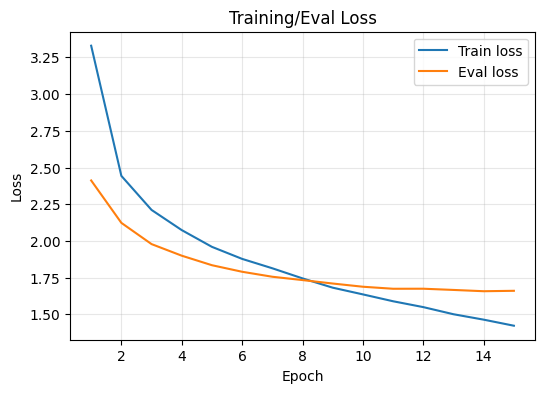

In [ ]:
import tqdm as tqdm
import glob
ckpt_dir = "/kaggle/working/"
os.makedirs(ckpt_dir, exist_ok=True)

train_losses = []
eval_losses = []

best_eval_loss = math.inf
best_ckpt_path = None

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for step, batch in tqdm.tqdm(
        enumerate(train_loader, start=1),
        total=len(train_loader),
        leave=False,
        desc=f"Train {epoch+1}"
    ):
        img, input_ids, attention_mask, labels = batch
        img = img.to(device, non_blocking=True)
        input_ids = input_ids.to(device, non_blocking=True)
        attention_mask = attention_mask.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        with torch.amp.autocast(device_type="cuda",enabled=use_fp16): # mixed precision training for faster training
            outputs = model(
                pixel_values=img,
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
            )
            loss = outputs.loss
            if loss.dim() > 0:
                loss = loss.mean()
            loss = loss / grad_accum_steps

        scaler.scale(loss).backward()
        running_loss += loss.item() * grad_accum_steps

        if step % grad_accum_steps == 0:# Graadient accumulation to effectively use large batch size on small GPUs
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        
    epoch_train_loss = running_loss / max(1, len(train_loader))
    train_losses.append(epoch_train_loss)

    model.eval()
    test_running_loss = 0.0
    test_batches = 0
    with torch.no_grad():
        for batch in tqdm.tqdm(
            test_loader,
            total=len(test_loader),
            leave=False,
            desc=f"Eval {epoch+1}"
        ):
            img, input_ids, attention_mask, labels = batch
            img = img.to(device, non_blocking=True)
            input_ids = input_ids.to(device, non_blocking=True)
            attention_mask = attention_mask.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with torch.amp.autocast(device_type="cuda",enabled=use_fp16):
                outputs = model(
                    pixel_values=img,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                )
                loss = outputs.loss
                if loss.dim() > 0:
                    loss = loss.mean()

            test_running_loss += loss.item()
            test_batches += 1

    epoch_test_loss = test_running_loss / max(1, test_batches)
    eval_losses.append(epoch_test_loss)

    print(f"Epoch {epoch+1} done | avg_train_loss={epoch_train_loss:.4f} | avg_test_loss={epoch_test_loss:.4f}")

    if epoch_test_loss < best_eval_loss:
        # Update best eval loss
        best_eval_loss = epoch_test_loss
        
        # Save the improved model
        ckpt_path = os.path.join(ckpt_dir, f"epoch_{epoch+1:03d}.pt")
        save_obj = {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scaler_state_dict": scaler.state_dict(),
            "avg_train_loss": epoch_train_loss,
            "avg_eval_loss": epoch_test_loss,
            "grad_accum_steps": grad_accum_steps,
            "max_grad_norm": max_grad_norm,
            "use_fp16": use_fp16,
        }
        torch.save(save_obj, ckpt_path)
        print(f"Saved improved checkpoint to {ckpt_path} (eval_loss={epoch_test_loss:.4f})")
        
        # Keep only latest 3 improved checkpoints
        checkpoint_pattern = os.path.join(ckpt_dir, "epoch_*.pt")
        checkpoint_files = glob.glob(checkpoint_pattern)
        
        if len(checkpoint_files) > 3:  
            # Sort by modification time (newest first)
            checkpoint_files.sort(key=os.path.getmtime, reverse=True)
            
            # Remove old checkpoints (keep only the latest 3)
            old_checkpoints = checkpoint_files[3:]
            
            for old_ckpt in old_checkpoints:
                try:
                    os.remove(old_ckpt)
                    print(f"Removed old improved checkpoint: {os.path.basename(old_ckpt)}")
                except Exception as e:
                    print(f"Error removing {os.path.basename(old_ckpt)}: {e}")
        
        # Also save as best.pt (the most recent improvement)
        best_ckpt_path = os.path.join(ckpt_dir, "best.pt")
        torch.save(save_obj, best_ckpt_path)
        print(f"Updated best checkpoint: {best_ckpt_path} (eval_loss={best_eval_loss:.4f})")
        
    else:
        print(f"No improvement (eval_loss={epoch_test_loss:.4f} >= best={best_eval_loss:.4f}), skipping save")
    
print("Training complete.")
    

plt.figure(figsize=(6,4))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train loss")
plt.plot(range(1, len(eval_losses)+1), eval_losses, label="Eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training/Eval Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plot_path = "/kaggle/working/loss_curve.png"
plt.savefig(plot_path, bbox_inches="tight", dpi=150)
print(f"Saved loss plot to {plot_path}")


In [ ]:
# best_ckpt = "/kaggle/working/best.pt"
# model = VisionTextModel(vit_encoder, proj, text_decoder).to(device)
# model = nn.DataParallel(model)
# state = torch.load(best_ckpt, map_location=device)
# model.load_state_dict(state["model_state_dict"])
# print(f"Loaded best checkpoint from {best_ckpt}")
# if tokenizer.bos_token_id is not None:
#     model.module.gpt2.config.decoder_start_token_id = tokenizer.bos_token_id

model.eval()
with torch.no_grad():
    batch = next(iter(test_loader))
    img, input_ids, attention_mask, labels = batch
    
    image_index = 7  
    single_img = img[image_index:image_index+1].to(device, non_blocking=True)
    single_labels = labels[image_index:image_index+1]
    
    encoder_outputs = model.module.vit(pixel_values=single_img)
    projected = model.module.proj(encoder_outputs.last_hidden_state)
    
    encoder_attention_mask = torch.ones(
        projected.size()[:-1], 
        dtype=torch.long, 
        device=projected.device
    )
    
    start_token = tokenizer.bos_token_id if tokenizer.bos_token_id else tokenizer.eos_token_id
    input_ids_start = torch.full((1, 1), start_token, dtype=torch.long, device=device)
    
    generated_ids = model.module.gpt2.generate(
        input_ids=input_ids_start,
        encoder_hidden_states=projected,        
        encoder_attention_mask=encoder_attention_mask, 
        
        # Generation settings for quality output
        max_new_tokens=64,
        do_sample=True,                         
        repetition_penalty=1.2,                # Prevent loops
        no_repeat_ngram_size=3,               # Prevent n-gram repetition
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
# Decode results
labels_for_decode = single_labels.detach().clone().to('cpu')
IGNORE_INDEX = -100
pad_id = tokenizer.pad_token_id
if pad_id is None:
    pad_id = tokenizer.eos_token_id

labels_for_decode[labels_for_decode == IGNORE_INDEX] = pad_id
labels_for_decode = labels_for_decode.to(torch.long).tolist()
label_texts = tokenizer.batch_decode(labels_for_decode, skip_special_tokens=True)

pred_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
# Print result for single sample
print(f"\n--- SINGLE IMAGE RESULTS ---")
print(f"Predicted: {pred_texts[0]}")
print("________________________")
print(f"Ground Truth: {label_texts[0]}")


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



--- SINGLE IMAGE RESULTS ---
Predicted: changed in radiologic interpretation. The original report is unchanged from the prior examination." "The heart size appears normal with no cardiomegaly or mediastinal shift observed, and there are clear lungs bilaterally consistent for acute cardiac failure (CVC). There's a small right pleural effusion on both sides
________________________
Ground Truth: Opacification of the left lung base is indeterminate, with a possible retrocardiac mass suggestive of a neumonadic process. Further diagnostic workup, including radiologist consultation after completion of treatment, is recommended.


Federated Learning Setup

In [ ]:
# Split the data into 2 clients
c_train_ds,c2_train_ds = random_split(train_ds, [0.5, 0.5], generator=torch.Generator().manual_seed(42))
c1_train_loader,c2_train_loader = DataLoader(c1_train_ds,batch_size=32, shuffle=True), DataLoader(c2_train_ds,batch_size=32, shuffle=True)

In [ ]:
def train_local_model(model, train_loader,local_optimizer, epochs=2):
 
    for epoch in range(epochs):
    # ---- TRAIN ----
        model.train()
        running_loss = 0.0
    
        for step, batch in tqdm.tqdm(
            enumerate(train_loader, start=1),
            total=len(train_loader),
            leave=False,
            desc=f"Train {epoch+1}"
        ):
            img, input_ids, attention_mask, labels = batch
            img = img.to(device, non_blocking=True)
            input_ids = input_ids.to(device, non_blocking=True)
            attention_mask = attention_mask.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
    
            with torch.amp.autocast(device_type="cuda",enabled=use_fp16):
                outputs = model(
                    pixel_values=img,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                )
                loss = outputs.loss
                if loss.dim() > 0:
                    loss = loss.mean()
                loss = loss / grad_accum_steps
    
            scaler.scale(loss).backward()
            running_loss += loss.item() * grad_accum_steps
    
            if step % grad_accum_steps == 0:
                scaler.unscale_(local_optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                scaler.step(local_optimizer)
                scaler.update()
                local_optimizer.zero_grad()
    
        epoch_train_loss = running_loss / max(1, len(train_loader))
    return model.state_dict(),epoch_train_loss    



def evaluate(model,test_loader):

    model.eval()
    test_running_loss = 0.0
    test_batches = 0
    with torch.no_grad():
        for batch in tqdm.tqdm(
            test_loader,
            total=len(test_loader),
            leave=False
        ):
            img, input_ids, attention_mask, labels = batch
            img = img.to(device, non_blocking=True)
            input_ids = input_ids.to(device, non_blocking=True)
            attention_mask = attention_mask.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with torch.amp.autocast(device_type="cuda",enabled=use_fp16):
                outputs = model(
                    pixel_values=img,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                )
                loss = outputs.loss
                if loss.dim() > 0:
                    loss = loss.mean()

            test_running_loss += loss.item()
            test_batches += 1

    epoch_test_loss = test_running_loss / max(1, test_batches)
    print(f"avg_test_loss = {epoch_test_loss:.4f}")
    
            
            

In [19]:
def FedAvg(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i][k].float() for i in range(len(client_models))], dim=0).mean(0)
    global_model.load_state_dict(global_dict)
    return global_model

In [ ]:
import tqdm as tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
global_model = VisionTextModel(vit_encoder, proj, text_decoder).to(device)

global_model = nn.DataParallel(global_model)

print(f"Total training parameters:{sum(p.numel() for p in global_model.parameters())}")
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
for p in global_model.module.vit.parameters():
    p.requires_grad=False 

clients = [c1_train_loader, c2_train_loader]
num_clients = len(clients)
rounds = 30
for round_no in range(rounds):
    print(f"Round: {round_no+1}")
    client_models = []

    for train_loader in clients:
        local_model = nn.DataParallel(VisionTextModel(vit_encoder, proj, text_decoder).to(device))
        local_model.load_state_dict(global_model.state_dict())

        for p in local_model.module.vit.parameters():
            p.requires_grad=False
        
        local_optimizer = torch.optim.AdamW(local_model.parameters(), lr=1e-5)
        client_state_dict,epoch_loss = train_local_model(local_model,train_loader,local_optimizer,epochs=1)
        client_models.append(client_state_dict)
        del local_model 
        torch.cuda.empty_cache() 

    global_model = FedAvg(global_model, client_models)

    evaluate(global_model,test_loader)        

/tmp/ipykernel_36/855227569.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Total training parameters:101805696
Round: 1


Train 1:   0%|          | 0/118 [00:00<?, ?it/s]`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


avg_test_loss = 2.8155
Round: 2


avg_test_loss = 2.3669
Round: 3


avg_test_loss = 2.1740
Round: 4


avg_test_loss = 2.0640
Round: 5


avg_test_loss = 1.9855
Round: 6


avg_test_loss = 1.9257
Round: 7


avg_test_loss = 1.8807
Round: 8


avg_test_loss = 1.8424
Round: 9


avg_test_loss = 1.8161
Round: 10


avg_test_loss = 1.7918
Round: 11


avg_test_loss = 1.7707
Round: 12


avg_test_loss = 1.7520
Round: 13


avg_test_loss = 1.7408
Round: 14


avg_test_loss = 1.7293
Round: 15


avg_test_loss = 1.7128
Round: 16


avg_test_loss = 1.7037
Round: 17


avg_test_loss = 1.6948
Round: 18


avg_test_loss = 1.6887
Round: 19


avg_test_loss = 1.6887
Round: 20


avg_test_loss = 1.6765
Round: 21


avg_test_loss = 1.6819
Round: 22


avg_test_loss = 1.6754
Round: 23


avg_test_loss = 1.6694
Round: 24


avg_test_loss = 1.6725
Round: 25


avg_test_loss = 1.6808
Round: 26


avg_test_loss = 1.6740
Round: 27


avg_test_loss = 1.6756
Round: 28


avg_test_loss = 1.6743
Round: 29


avg_test_loss = 1.6753
Round: 30


avg_test_loss = 1.6852
